<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project3_tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Tsunami
In this project, we will use Dedalus to model the propagation of Tsunami waves. Tsunami typically have wavelengths larger than 100km and periods of about 1 hour. Since their wavelength is much larger than the depth of the ocean, Tsunami can be modelled using the shallow water equations. 

Here, we will use Dedalus to solve an initial value problem for the shallow water equations. We will generate a Tsunami using a localized disturbance to the water height. 

Student tasks are in [Section 1.3]( #section1pt3 ), [Section 2.3]( #section2pt3 ), and [Section 3.3]( #section3pt3 ).

## Setup
If you are using Google colab, run the script below to install Dedalus

## 1.  1D shallow water equations
Let's start by solving the shallow water equations in 1D with periodic boundary conditions in our spatial variable, $x$. The script below solves the following equations:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$


In these equations, $g$ is the constant gravitational acceleration, $u$ is the velocity in the $x$ direction, $H$ is the resting height, and $h$ is the height of the free surface relative to $H$. Note that the terms on the right hand side are nonlinear in our dependent variables, and we will use an explicit timestepping method for these terms. Recall that Dedalus uses explicit timestepping for terms on the right hand side of the inputted equation.

Because we are interested in an application to Tsunami, we will solve the equations using dimensional variables. It is convenient to define simulation units at the start of the script so that we can be explicit about the units.

We will start with the following initial conditions:
$$ h=e^{-(x-x_1)^2/w_1^2} $$
$$ u=0 $$
where $x_1$ is the center and $w_1=100$ km is the width of the Gaussian perturbation. 

To see how the waves change as they approach shallow water, we will set the resting water depth to include a localized seamount using the form:
$$ H=H_0-(H_0-H_{min})e^{(-(x-x_2)^2/w_2^2)} $$
where $x_2$ is the location of the seamount, $H_0=4$ km is the depth of the ocean away from the seamount, and $H_{min}$ is the minimum water depth above the seamount. Note that since $H\ll w$, the shallow water approximation is appropriate here.

### 1.1  Dedalus script to solve the 1D shallow water equations

The script below solves the 1D shallow water equations with the initial conditions given above.

In [1]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size
Nx = 512 # The number of gridpoints in x
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
w1 = 20 * kilometer # Width of the initial perturbation
x1 = 200 * kilometer # Center of the initial perturbation
x2 = 500 * kilometer # Center of the seamount
w2 = 100 * kilometer # Width of the seamount
H_min = 100 * meter # minimum depth above the seamount

timestep = 60 * second # Specify the timestep
stop_sim_time = 100 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(0, Lx))
x = dist.local_grid(x_basis)

# Specify the Fields and set the initial conditions
u = dist.Field(name='u', bases=x_basis)
h = dist.Field(name='h', bases=x_basis)
H = dist.Field(name='H', bases=x_basis)
h.change_scales(1) 
H.change_scales(1) 
u.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-(x-x2)**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2.0/w1**2.0)  # Initialize the height with a Gaussian function with width set above
u['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u)")
problem.add_equation("dt(h) + dx(H*u) = - dx(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

2024-12-18 21:56:34,479 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+01/s
2024-12-18 21:56:34,481 __main__ 0/1 INFO :: Starting main loop
2024-12-18 21:56:34,666 solvers 0/1 INFO :: Simulation stop time reached.
2024-12-18 21:56:34,666 solvers 0/1 INFO :: Final iteration: 100
2024-12-18 21:56:34,667 solvers 0/1 INFO :: Final sim time: 6000.0
2024-12-18 21:56:34,668 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2233 sec
2024-12-18 21:56:34,669 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.03094 sec
2024-12-18 21:56:34,670 solvers 0/1 INFO :: Run time (iter 10-end): 0.1538 sec
2024-12-18 21:56:34,670 solvers 0/1 INFO :: CPU time (iter 10-end): 4.271e-05 cpu-hr
2024-12-18 21:56:34,670 solvers 0/1 INFO :: Speed: 1.196e+06 mode-stages/cpu-sec


In [2]:
np.sqrt(g*H0)

np.float64(198.09088823063013)

In [3]:
np.shape(t_save)

(101,)

### 1.2  Plotting
The code below will make a movie of the height.

2024-12-18 21:56:34,787 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-12-18 21:56:34,788 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp5pudfy2z/temp.m4v


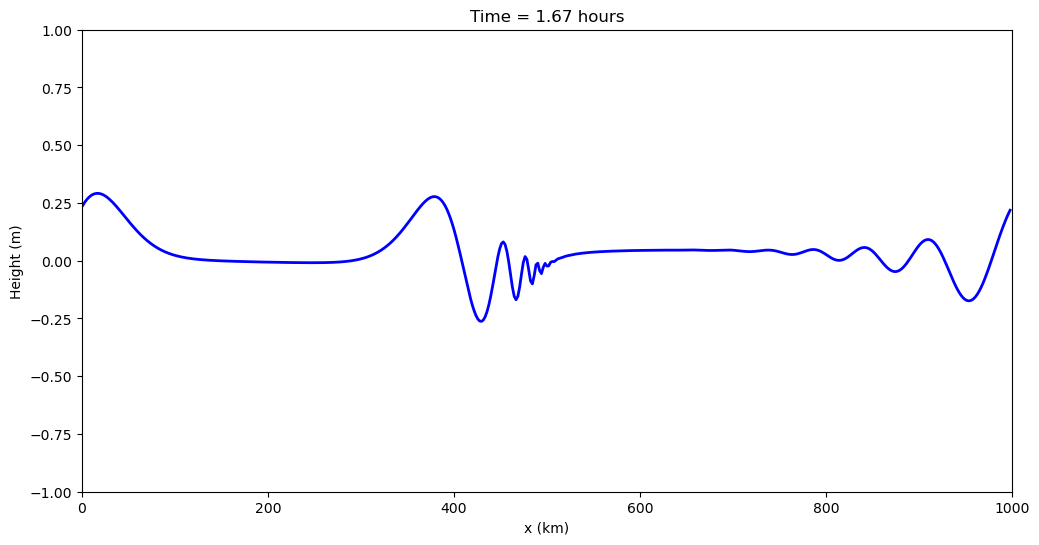

In [4]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Specify the axis limits and labels
plt.xlim((0, Lx / (1*kilometer)))            
plt.ylim((-1, 1))
plt.xlabel('x (km)')
plt.ylabel('Height (m)')

# Create objects that will change during the animation
txt_title = plt.title('')
height, = plt.plot([], [], 'b', lw=2)    

# Define an animation function
def drawframe(n):
    height.set_data(x/(1*kilometer), h_save[n,:])
    txt_title.set_text('Time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


### 1.3 Student investigation
<a id='section1pt3'></a>
In the cells below, provide an expression for the expected wave speed and state any assumptions that are necessary to arrive at this. Then plot the wave speed from the output above and compare this with the expected value. 

In [5]:
xinds = []
for i in range (101):

    maximum = np.max(h_save[i][100:])
    xinds.append(np.where(h_save[i]==maximum)[0][0] )
   


In [6]:
t_save

[np.float64(0.0),
 np.float64(60.0),
 np.float64(120.0),
 np.float64(180.0),
 np.float64(240.0),
 np.float64(300.0),
 np.float64(360.0),
 np.float64(420.0),
 np.float64(480.0),
 np.float64(540.0),
 np.float64(600.0),
 np.float64(660.0),
 np.float64(720.0),
 np.float64(780.0),
 np.float64(840.0),
 np.float64(900.0),
 np.float64(960.0),
 np.float64(1020.0),
 np.float64(1080.0),
 np.float64(1140.0),
 np.float64(1200.0),
 np.float64(1260.0),
 np.float64(1320.0),
 np.float64(1380.0),
 np.float64(1440.0),
 np.float64(1500.0),
 np.float64(1560.0),
 np.float64(1620.0),
 np.float64(1680.0),
 np.float64(1740.0),
 np.float64(1800.0),
 np.float64(1860.0),
 np.float64(1920.0),
 np.float64(1980.0),
 np.float64(2040.0),
 np.float64(2100.0),
 np.float64(2160.0),
 np.float64(2220.0),
 np.float64(2280.0),
 np.float64(2340.0),
 np.float64(2400.0),
 np.float64(2460.0),
 np.float64(2520.0),
 np.float64(2580.0),
 np.float64(2640.0),
 np.float64(2700.0),
 np.float64(2760.0),
 np.float64(2820.0),
 np.float64(

velocity= 0.1953125 km/s


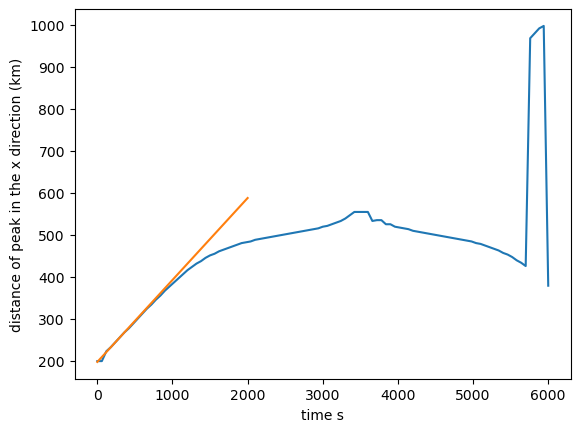

In [7]:
from scipy.stats import linregress
plt.plot(t_save,np.array(xinds)*1000/512)

fit = linregress(t_save[3:6],np.array(xinds[3:6])*1000/512)
plt.plot([0,2000],[fit.slope*0+fit.intercept,fit.slope*2000+fit.intercept])
print('velocity= ' + str(fit.slope) + ' km/s')
plt.xlabel('time s')
plt.ylabel('distance of peak in the x direction (km)')
plt.show()

In [8]:

def local_gradient(arr):
    # Ensure the input is a NumPy array
    arr = np.asarray(arr)
    
    # Length of the array
    n = len(arr)
    
    # Initialize an array to store the gradients
    gradients = np.zeros_like(arr)
    
    # Calculate the local gradient for each element with enough neighbors
    for i in range(3, n - 3):
        # Compute the gradient using two measurements on each side
        gradient = (arr[i + 3] - arr[i - 3]) / 6
        # Store the gradient
        gradients[i] = gradient
    
    # Boundary elements can be set to NaN or handled differently if required
    gradients[:3] = np.nan
    gradients[-2:] = np.nan
    
    return gradients

# Example usage

grad = local_gradient(np.array(xinds)*1000/(60*512)*1000)




[]

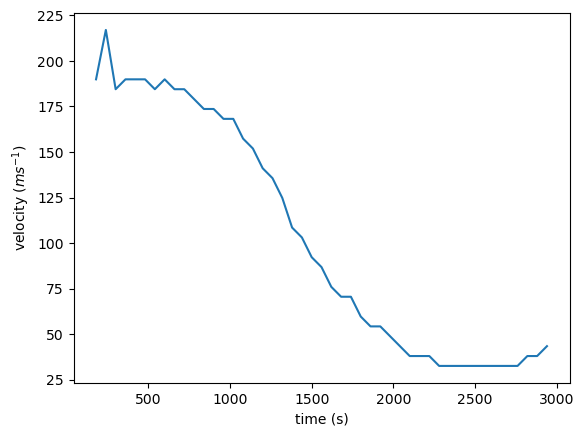

In [9]:
plt.plot(t_save[0:50],grad[0:50])
plt.xlabel('time (s)')
plt.ylabel(r'velocity ($ms^{-1}$)')
plt.plot()

Text(0.5, 1.0, 'tsunami numerical simulation, and prediction')

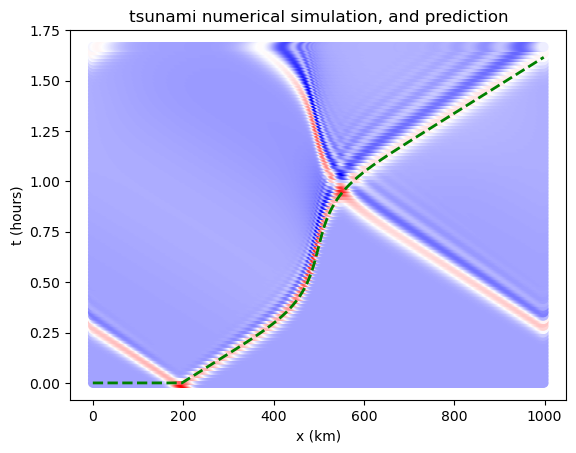

In [10]:
xx,tt = np.meshgrid(x*1e-3,np.array(t_save)/3600)

plt.scatter(xx,tt,c=h_save,cmap =   'bwr')

exp_speed = (g*H['g'])**0.5
exp_speed[:102] = np.inf   # get rid of times when 
cum_tim = np.cumsum(1000000/512/exp_speed)
cum_tim[:102] = 0


#shift_tim = np.maximum(cum_tim - np.interp(200000,x,cum_tim),0)
plt.plot(x/1000,cum_tim/3600,color='green',linewidth = 2, linestyle ='--')
plt.xlabel('x (km)')
plt.ylabel('t (hours)')
plt.title('tsunami numerical simulation, and prediction')

----
$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

Assuming h is small compared to H, u will be small too. Hence the RH of both the top and bottoom eqs can be assumed= 0 as they involve products of small terms. Cross-differentiating the resulting equations and eliminating the common term gives:
$$\frac{\partial^2u}{\partial t^2} - gH\frac{\partial^2u}{\partial x^2} = 0 $$

Scaling the two terms relative to each other and setting $\frac{t}{x} = u$, results in:
$$ u \approx \sqrt{g*H} \approx 200 \hspace{5pt} ms^{-1}  $$



The 2D figure showing the evolution of the peak with time shows the expected location of the peak based on the height of the ocean (presence of seamount). The height allows calculation of speed at every point, and hence the position of the peak in space. The prediction matches closely to the numerical simultion.

In addition the peak can be tracked through time, and veloity calculated. Ignoring the initiation of the wave where the peak tracking fails (and the wave is accellerating) the initial observed velocity is roughly 185 $ms^{-1}$. The velocity is later reduced as the seamount forces an increase in the amplitude of the wave, hence transferring energy back to gravitational potential energy. Equivalently the depth of the ocean decreases, therefore $\sqrt{gH}$ decreases, and so does the velocity.  This is close to the expected theoretical result (it is marginally smaller as I've calculated the gradient using multiple points in each direction, likely implying that it's the discretisation in space and time that causes this difference)



----

## 2.  2D Shallow water equations

Now, let's see how things change if we move to two dimensions. The script below solves the 2D shallow water equations:

$$ \partial_t u + g \partial_x(h) = - u*\partial_x u - v*\partial_y u$$
$$ \partial_t u + g \partial_y(h) = - u*\partial_x v - v*\partial_y v$$
$$ \partial_t h + H (\partial_x(u) + \partial_y(v)) = -\partial_x(h*u) - \partial_y(h*v)$$

We will solve these equations in a square domain with periodic boundary conditions. We will again initialize with a Gaussian height disturbance and with no water motion, but this time in 2D:

$$ h=e^{-(x^2+y^2)/w^2} $$
$$ u=0 $$
$$ v=0 $$

### 2.1  Dedalus script to solve the 2D shallow water equations

In [11]:
def calculate (h_init):
    # Import the required packages
    import numpy as np
    import dedalus.public as dedalus
    import logging
    import matplotlib.pyplot as plt

    logger = logging.getLogger(__name__)

    # Define the simulation units. This is optional, but will help us keep track of units
    meter = 1
    kilometer = meter * 1e3
    second = 1
    minute = 60
    hour = 3600
    day = hour * 24

    # Specify the simulation parameters
    Lx = 1000 * kilometer # The domain size in x
    Ly = 1000 * kilometer # The domain size in y
    Nx = 64 # The number of gridpoints in x
    Ny = 64 # The number of gridpoints in y
    g = 9.81 * meter / second**2 # Gravitational acceleration
    H = 4 * kilometer # Reference ocean depth
    width = 100 * kilometer # Set the width of the initial Gaussian

    timestep = 60 * second # Specify the timestep
    stop_sim_time = 30 * minute # Specify the stopping time

    timestepper = dedalus.RK222
    max_timestep = 0.125

    # Bases
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
    ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

    x, y = dist.local_grids(xbasis, ybasis)

    # Fields
    u = dist.Field(name='u', bases=(xbasis, ybasis))
    v = dist.Field(name='v', bases=(xbasis, ybasis))
    h = dist.Field(name='h', bases=(xbasis, ybasis))

    # Initial conditions
    h.change_scales(1) # Set values on regular grid
    u.change_scales(1)
    v.change_scales(1)
    h['g'] = h_init*np.exp(-(x**2+y**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
    u['g'] = 0
    v['g'] = 0

    # Operators
    dx = lambda a: dedalus.Differentiate(a, coords['x'])
    dy = lambda a: dedalus.Differentiate(a, coords['y'])

    # Problem
    problem = dedalus.IVP([u, v, h], namespace=locals())
    problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
    problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
    problem.add_equation("dt(h) + H*(dx(u) + dy(v)) = - dx(h*u) - dy(h*v)")

    # Solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Analysis
    snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
    snapshots.add_task(h, name='h')
    snapshots.add_task(u, name='u')
    snapshots.add_task(v, name='v')

    h.change_scales(1)
    h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
    # Main loop
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration-1) % 1 == 0:
                h.change_scales(1)
                h_save.append(np.copy(h['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing
    return h_save, t_save

In [12]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Reference ocean depth
width = 100 * kilometer # Set the width of the initial Gaussian

timestep = 60 * second # Specify the timestep
stop_sim_time = 30 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))

# Initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
h['g'] = 1*np.exp(-(x**2+y**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = 0
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + H*(dx(u) + dy(v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing


2024-12-18 21:56:43,140 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 9.4e+01/s
2024-12-18 21:56:43,163 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-18 21:56:43,193 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2024-12-18 21:56:43,221 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2024-12-18 21:56:43,249 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2024-12-18 21:56:43,278 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2024-12-18 21:56:43,307 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+02/s
2024-12-18 21:56:43,338 subsystems 0/1 INFO :: Building subproblem matric

### 2.2  Plotting
The code below will make a movie of the height as a function of x and y

In [13]:
np.shape(h_save)

(31, 64, 64)

2024-12-18 21:56:44,015 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-12-18 21:56:44,016 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpgf7g9it2/temp.m4v


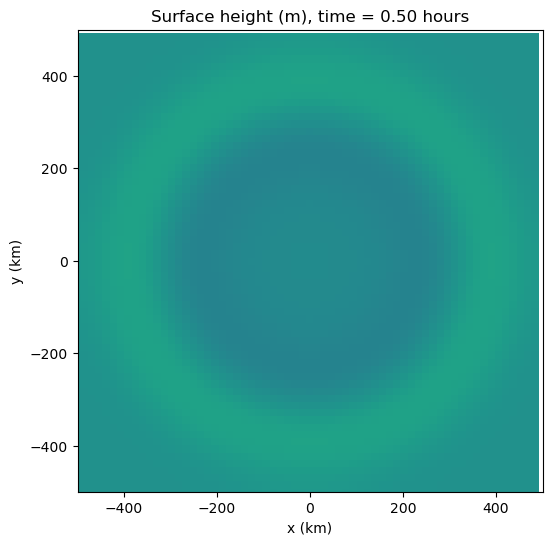

In [14]:
# create a figure and axes

fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))  

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:], vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))   
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))            
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


### 2.3 Student investigation
<a id='section2pt3'></a>
Notice how the amplitude of the Tsunami wave decreases with distance from the source location. In the cell below, make a prediction for how the wave amplitude will vary as a function of distance from the origin (x=0, y=0) using conservation of energy. Then, make a plot or plots comparing your prediction for the wave amplitude compared with the results from the simulation. 

Try out several different possible initial conditions for the surface height, $h$. How does the shape of the resulting waves change?

ADD PREDICTION OF WAVE AMPLITUDE HERE (a few sentences and/or equations)

Consider the main peak has a constant width w through time (after the initiation period).  We can then integrate the the peak allong z (between 0 and H(t)). Assuming a square peak we get :
$$ GPE_{2D slice} = \frac{w \rho g H(t)^2} {2}$$

Now adding the third dimension (assuming base area of annulus is diameter * width)

$$ GPE_{tot} = \frac{2 \pi R(t) w \rho g H(t)^2} {2}$$

Rearranging gives:
$$ H(t) \propto \frac{1}{\sqrt{R(t)}}$$

The proportionality constant is determined below.

2024-12-18 21:56:55,223 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2024-12-18 21:56:55,247 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+02/s
2024-12-18 21:56:55,277 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2024-12-18 21:56:55,306 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2024-12-18 21:56:55,340 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2024-12-18 21:56:55,371 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2024-12-18 21:56:55,401 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2024-12-18 21:56:55,431 subsystems 0/1 INFO :: Building subproblem matric

/tmp/ipykernel_387753/407946779.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r[i] = np.where(h_save[i][31][32:] == amp[i])[0]
/tmp/ipykernel_387753/407946779.py:16: RuntimeWarning: divide by zero encountered in divide
  pred = ind[j]/np.sqrt(np.array(r))


2024-12-18 21:56:56,029 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2024-12-18 21:56:56,059 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2024-12-18 21:56:56,089 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+02/s
2024-12-18 21:56:56,091 __main__ 0/1 INFO :: Starting main loop
2024-12-18 21:56:56,421 solvers 0/1 INFO :: Simulation stop time reached.
2024-12-18 21:56:56,422 solvers 0/1 INFO :: Final iteration: 30
2024-12-18 21:56:56,422 solvers 0/1 INFO :: Final sim time: 1800.0
2024-12-18 21:56:56,422 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2763 sec
2024-12-18 21:56:56,423 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1423 sec
2024-12-18 21:56:56,423 solvers 0/1 INFO :: Run time (iter 10-end): 0.1862 sec
2024-12-18 21:56:56,424 solvers 0/1 INFO :: CPU time (iter 10-end): 5.171e-05 cpu-hr
2024

Text(0.5, 0, 'time (s)')

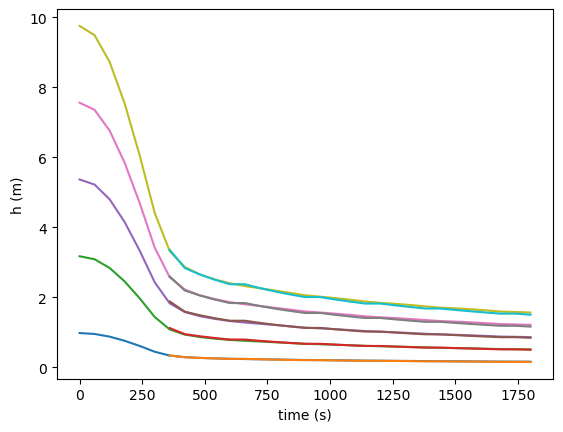

In [15]:
# ADD CODE TO MAKE PLOTS HERE
amps_h = {}
r_t = {}
ind =np.array([0.75,2.5,4.2,5.8,7.5])

for j, h_in in enumerate(np.linspace(1,10,5)):
    h_save,t_save = calculate(h_in)
    amp = np.zeros(31)
    r = np.zeros(31)

    for i in range(31):
        middle_slice = h_save[i][31][32:]
        amp[i] = np.max(middle_slice)
        
        r[i] = np.where(h_save[i][31][32:] == amp[i])[0] 
    pred = ind[j]/np.sqrt(np.array(r))
    pred[0] =1
    plt.plot(t_save,amp)
    plt.plot(t_save,pred)
    
    #plt.plot(t_save,amp/h_in) #'collapse onto one curve'
   
    amps_h[f'{h_in}'] = amp
plt.ylabel('h (m)')
plt.xlabel('time (s)')

Text(0.5, 0, 'Initial height (m)')

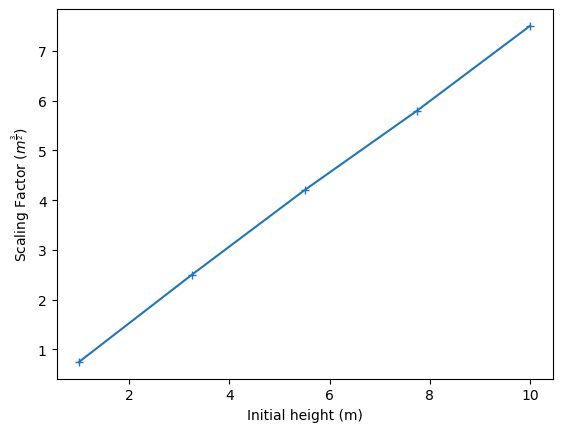

In [16]:
plt.plot(np.linspace(1,10,5),ind,marker = '+')
plt.ylabel(r'Scaling Factor ($m^{\frac{3}{2}}$)' )
plt.xlabel('Initial height (m)')

In [17]:
fit = linregress(np.linspace(1,10,5),ind)
fit

LinregressResult(slope=np.float64(0.7466666666666666), intercept=np.float64(0.04333333333333389), rvalue=np.float64(0.9998937244271403), pvalue=np.float64(1.3151555317355785e-06), stderr=np.float64(0.006285393610546272), intercept_stderr=np.float64(0.039938223901353535))

ADD DISCUSSION HERE (~1 paragraph)

----

When varying the initial height the shape of the curve is just stretched in the z direction. This makes sense as the initial height could be scaled out as a dimensional variable, leaving behind the equation used for calculating the curve with initial height 1m.

In addition we observe that the $\frac{A}{\sqrt{R}}$ prediction is good, and we are able to pick values of A to get a good fit. Furthermore
 the value of A scales linearly with initial height.
The constant of proportionality determined is 0.75 * $h_{init}$. This makes sense, as this predicts the total energy scales with $h^2$ which is consistent with the reasoning used to predict the height as a function of the radius.


----

### 3.1  Dedalus script for 2D shallow water equations on a sphere

## 3. Shallow water equations on a sphere

Of course the Earth isn't a flat plane. A great strength of Dedalus is its flexibility to solve equations in various geometries. The script below solves the 2D shallow water equations on a spherical shell, where the azimuth and colatitude are the independent variables. The colatitude is the complementary angle to the latitude such that the colatitude is $0^\circ$ at the North Pole, $90^\circ$ at the Equator, and $180^\circ$ at the South Pole. The spherical geometry also allows us to take into account the Earth's rotation in a realistic way. 

Specifically, we will solve the following equations:
$$ \partial_t \mathbf{u} + g \nabla h + 2 \Omega \hat{\mathbf{z}} \times \mathbf{u} = -\mathbf{u} \cdot \nabla \mathbf{u} $$
$$ \partial_t h+ H \nabla \cdot \mathbf{u} = -\nabla \cdot (h \mathbf{u}) $$

where $\mathbf{u}$ is the velocity vector, $\Omega$ is the Earth's angular velocity (in radians per second), and $\hat{\mathbf{z}}$ is a unit vector aligned with the North Pole. Note that we have written the equations above in vector form. Dedalus includes vector calculus operators that make it very natural to solve equations like this without worrying about the particular form of the vector operators in a curvilinear coordinate system.

In [21]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt
import numpy as np

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

2024-12-18 22:14:11,635 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 7.8e+01/s
2024-12-18 22:14:11,694 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 9.7e+01/s
2024-12-18 22:14:11,767 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 9.7e+01/s
2024-12-18 22:14:11,836 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 0s, Rate: 9.8e+01/s
2024-12-18 22:14:11,907 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 9.8e+01/s
2024-12-18 22:14:11,977 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 9.9e+01/s
2024-12-18 22:14:12,048 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 0s, Remaining: 0s, Rate: 9.9e+01/s
2024-12-18 22:14:12,121 subsystems 0/1 INFO :: Building subproblem matri

### 3.2  Plotting
The code below will make a movie of the height as a function of x and y

2024-12-09 16:55:50,711 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-12-09 16:55:50,712 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpjdfjbotn/temp.m4v


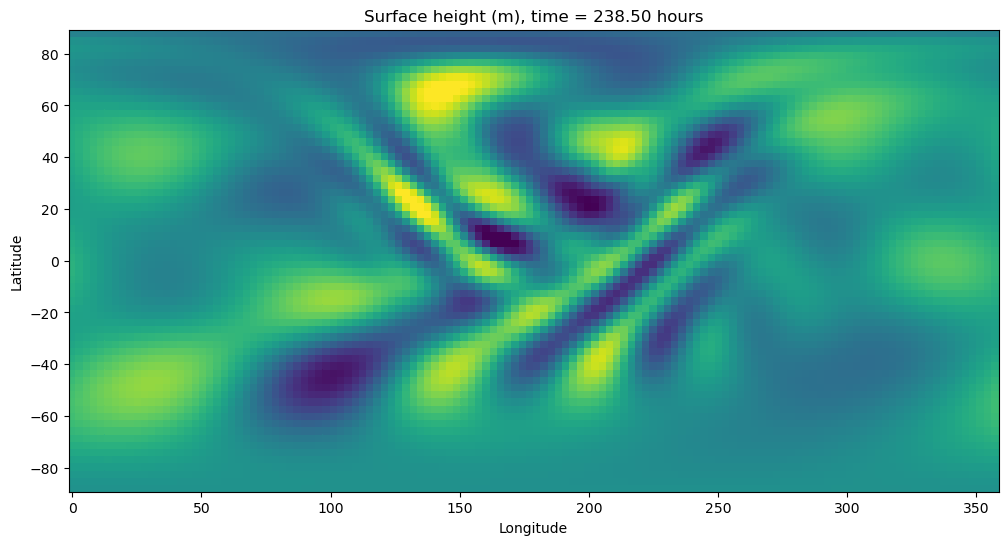

In [2]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)  

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels         
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

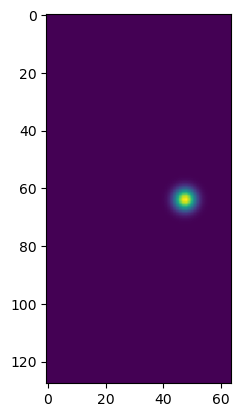

In [46]:

plt.imshow(h_save[0])

In [20]:
np.shape(h_save)

(145, 128, 64)

### 3.3 Student investigation
<a id='section3pt3'></a>
Create a virtual tide gauge by sampling the height at a point at a latitude of 45ºN and longitude of 90ºW and plot the timeseries of the height at this point in the cells below. Notice that as the gravity waves propagate around the Earth, their shape changes. Discuss physical mechanisms that might cause the shape of the wave to change as the wave propagates.

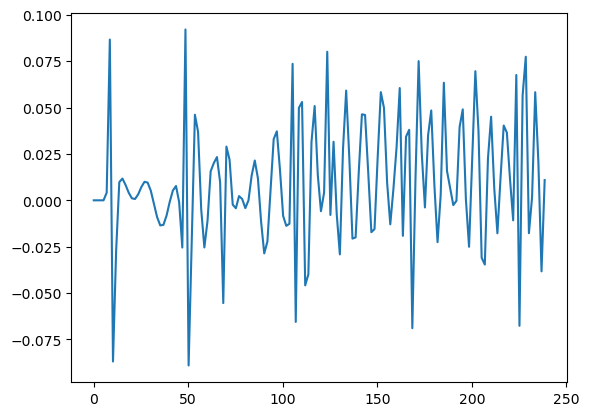

In [13]:
gague = h_save[:,int(128*3/4),int(3/4*64)]
plt.plot(np.array(t_save)/hour,gague)
plt.xlabel('time (hours)')
plt.ylabel('h (m)')

----

There are two reasons for why the shpe of the wave changes. The primary effect is that these waves are dispersive, and hence different wavelengths travel at different velocities. Therefore in the tide gague (and video) we can see single peaks split into multiple smaller peaks. In addition the different paths waves take means they eperience different coriolic accelleration, and therefore they do not return in phase to the initiationpoint. S instead of cancelling out, they superpose and create a complicated pattern.

In nature here are mutiple other factors that add up to this change in form. There are coastlines and ocean bed shapes that constrain the waves physically. In addition there are currents that either push, or stop the waves. The world is similarly not a perfect sphere (meaning even with no other factors waves would not return in phase). There is also frictional effects and finally the tides/ attraction from the moon may have some impact.

----


In the simulation above, the Tsunami wave travels around the planet many times. In reality, the waves will partially dissipate when they reach shorelines. In the spherical shallow water equation code above (or in a new code block below), add a forcing term to the shallow water equations that damps the waves for longitudes larger than $\pm 90^\circ$. Specifically, add a forcing function to the right hand side of the height equation of the following form:

$$ - (1/\tau) f(\phi) h$$

where

$$ f(\phi) = \frac{1}{2}\left(1+tanh\left(\frac{\phi-3\pi/2}{\pi/10}\right)\right) + \frac{1}{2}\left(1-tanh\left(\frac{\phi-\pi/2}{\pi/10}\right)\right) $$

and $\phi$ is the co-latitude in radians and $\tau$ is a damping timescale. A timescale of $\tau=0.1$ days should be sufficient to damp the waves.

With this damping term active, much more slowly propagating waves should be visible. These are shallow water Rossby waves. Estimate the east/west phase speed of these Rossby waves and compare them with the phase speed that you can infer from the simulation by plotting the height, $h$, as a function of longitude and time. Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.

In [107]:
# ADD CODE HERE TO SOLVE THE SHALLOW WATER EQUATIONS WITH DAMPING.
# YOU CAN START BY COPYING THE CODE ABOVE AND PASTING IT HERE
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3#

second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians
tau = 0.1*day

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)
f = dist.Field(name='f',bases = basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
f['g'] = 0.5*(1+np.tanh((phi-3*np.pi/2)/(np.pi/10))) + 0.5*(1-np.tanh((phi-np.pi/2)/(np.pi/10)))
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u) - 1/tau*f*h")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

2024-12-18 23:12:15,431 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 7.6e+01/s
2024-12-18 23:12:15,489 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 9.8e+01/s
2024-12-18 23:12:15,558 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s
2024-12-18 23:12:15,625 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s
2024-12-18 23:12:15,691 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s
2024-12-18 23:12:15,770 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 9.9e+01/s
2024-12-18 23:12:15,844 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 0s, Remaining: 0s, Rate: 9.9e+01/s
2024-12-18 23:12:15,920 subsystems 0/1 INFO :: Building subproblem matri

2024-12-18 23:11:31,033 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-12-18 23:11:31,033 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpkr2oi0dm/temp.m4v


KeyboardInterrupt: 

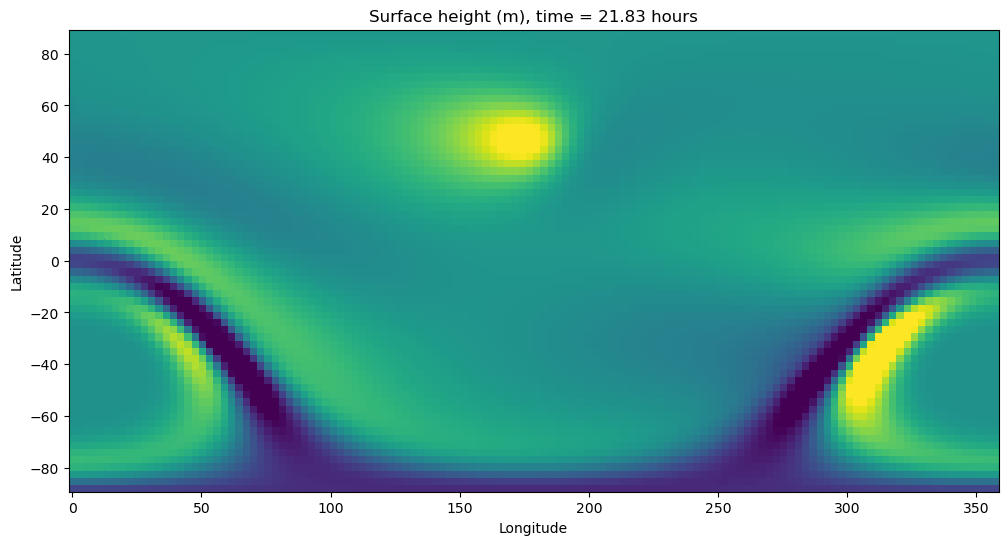

In [105]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)  

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels         
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

Text(0.5, 0, 'longitude')

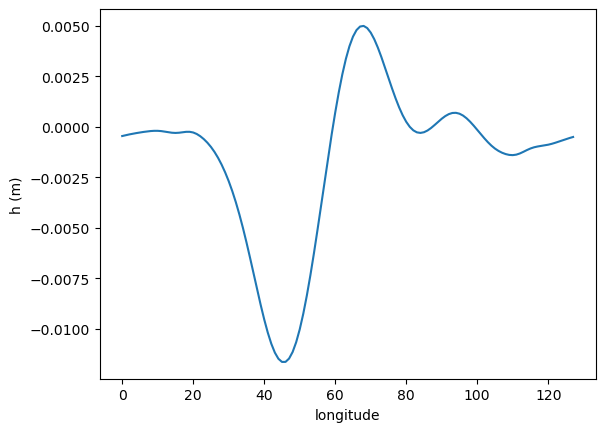

In [108]:
plt.plot(h_save[50,:,16]) #through longitude

plt.ylabel('h (m)')
plt.xlabel('longitude')

Text(0, 0.5, 'h (m)')

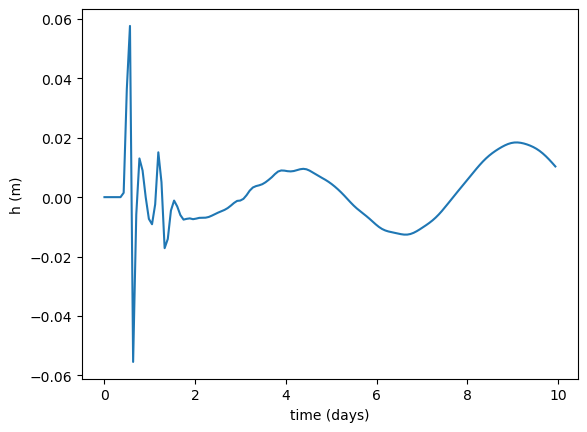

In [109]:
#through time
plt.plot(np.array(t_save)/day,h_save[:,64,16])
plt.xlabel('time (days)')
plt.ylabel('h (m)')

In [5]:
np.shape(h_save[:,:,31])

(145, 128)

In [16]:
h_modified = h_save[:,:,16]

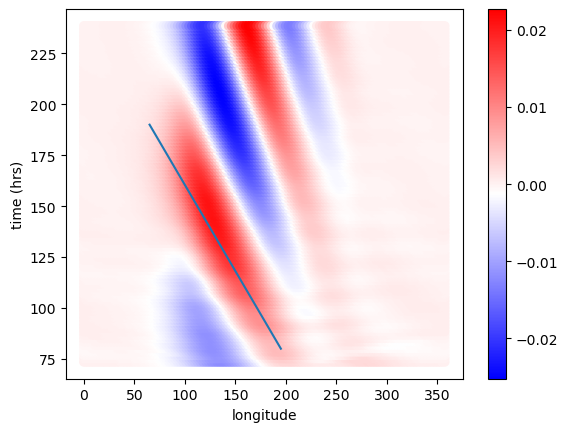

In [17]:
xx ,yy = np.meshgrid((np.squeeze(phi)*360/2/np.pi),np.array(t_save)/hour)
plt.scatter(xx[-100:,:],yy[-100:,:],c = h_modified[-100:,:], cmap =   'bwr' )
plt.xlabel('longitude')
plt.ylabel('time (hrs)')


plt.plot([195,65],[80,190])



plt.colorbar()

In [22]:
gradient = 130/110
6400000*np.sin(45*np.pi/180)/360*gradient / 3600

np.float64(4.126773582682432)

In [37]:
np.sin(np.pi/180*45)

np.float64(0.7071067811865475)

In [95]:
Omega = 2*np.pi/(24 *3600)

In [96]:
wavelength = 2*np.pi*6371000*np.sin(45*np.pi/180)*50/360

In [97]:
k_mod = 2*np.pi / (wavelength)

In [98]:
beta = 2*Omega*np.cos(45*np.pi/180)/6371000

In [99]:
beta/(2*k_mod**2)

np.float64(3.159830193219046)

------

The Rossby waves are observed after damping of the main waves. The phase speed at 45 $\degree$ North in the Westwards direction is roughly 4.1 $ms^{-1}$. In contrast we may find the formula for the phase speed by considering the dispersion relation and taking $\frac{d\omega}{dk}$ gives $-\frac{\beta}{k^2 + l^2}$. We can estimate k from the numerical simulation (and assuming l is equal to k) we can now calculate the theoretical phase speed at 45 $\degree$ N. The wavelength is estimated as 50 degrees hence reulting in 3.2 $ms^{-1}$ Westwards. The rough agreement is a good sign.

Note however, the large variance in speeds observed, visible in the movie. In the southern hemisphere the rossby waves seem to travel at nearly double the speed. This is likely because there is damping, hence the two hemispheres had different initial waves, hence different phase speeds. The waves similarly are formed at 90 degrees East and then disappear at 90 degrees West. This is due to the damping conditions imposed.

-----


## 4. Optional further investigations

* In the example of the shallow water equations on a sphere, introduce bathymetry by making $H$ a function of latitude and longitude. Make sure that you modify the equations in Dedalus appropriately. How do the waves behave when they encounter shallow water (e.g. a localized seamount)?

* It is quite difficult to simulate changing sea level (sometimes called wetting and drying), which is why the examples above do not include land. However, we can estimate the distance that a Tsunami will propagate using physical and dimensional arguments. Consider, for example, a flat, sloping beach. In the absence of energy dissipation, estimate the distance that a wave will propagate onshore. How could you modify this estimate to include energy dissipation (or drag)?